#ScriptSense HTR Project

This is a Handwritten Text Recognition Project, with the hybrid model of CNN, BiLSTM and Transformer Architecture.

*   This is made using the IAM dataset imported from Kaggle.
*   GPU is required to run this notebook, else it will be time-consuming.
*   Mount it with your Google Account (done within the code) to store the training checkpoints of the model.

##Step 1: Import Libraries & IAM Dataset
Here, we import the IAM Dataset from Kaggle, and import other relevant libraries.

In [ ]:
import kagglehub
nibinv23_iam_handwriting_word_database_path = kagglehub.dataset_download('nibinv23/iam-handwriting-word-database')
print('Data source import complete.')

Data source import complete.


In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

##Step 2: Preprocessing Module
Here, we parse the IAM dataset labels from words.txt, extract valid image paths and corresponding word labels, identify unique characters, determine the maximum label length, and create mappings between characters and integers for our model.

In [ ]:
IMAGE_SIZE = (128, 32)
BATCH_SIZE = 64
EPOCHS = 50
PADDING_TOKEN = 99

In [ ]:
DATA_INPUT_PATH = "/kaggle/input/iam-handwriting-word-database"

images_path = []
labels = []

def preprocess_dataset():
    characters = set()
    max_len = 0
    with open(os.path.join(DATA_INPUT_PATH, 'iam_words', 'words.txt'), 'r') as file:
        lines = file.readlines()

        for line_number, line in enumerate(lines):
            # Skip comments and empty lines
            if line.startswith('#') or line.strip() == '':
                continue

            # Split the line and extract information
            parts = line.strip().split()

            # Continue with the rest of the code
            word_id = parts[0]

            first_folder = word_id.split("-")[0]
            second_folder = first_folder + '-' + word_id.split("-")[1]

            # Construct the image filename
            image_filename = f"{word_id}.png"
            image_path = os.path.join(
                DATA_INPUT_PATH, 'iam_words', 'words', first_folder, second_folder, image_filename)

            # Check if the image file exists
            if os.path.isfile(image_path) and os.path.getsize(image_path):

                images_path.append(image_path)

                # Extract labels
                label = parts[-1].strip()
                for char in label:
                    characters.add(char)

                max_len = max(max_len, len(label))
                labels.append(label)

    characters = sorted(list(characters))

    print('characters: ', characters)
    print('max_len: ', max_len)
    # Mapping characters to integers.
    char_to_num = tf.keras.layers.StringLookup(
        vocabulary=list(characters), mask_token=None)

    # Mapping integers back to original characters.
    num_to_char = tf.keras.layers.StringLookup(
        vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
    )
    return characters, char_to_num, num_to_char, max_len

characters, char_to_num, num_to_char, max_len = preprocess_dataset()

characters:  ['!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
max_len:  19


This code preprocesses word images by resizing them without distortion, normalizing pixel values, ensuring consistent shape, and vectorizing text labels by mapping characters to padded integer sequences for training our model.

In [ ]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

def preprocess_image(image_path, img_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(
        label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]],
                   constant_values=PADDING_TOKEN)
    return label

##Step 3: Parsing Labels & Creating Batches
This code creates a TensorFlow dataset by preprocessing images and labels, batching them, and optimizing performance with caching and prefetching for efficient training in the ScriptSense HTR model.

In [ ]:
def process_images_labels(image_path, label):
    image = preprocess_image(image_path, IMAGE_SIZE)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
    AUTOTUNE = tf.data.AUTOTUNE
    print('len(image_paths): ', len(image_paths))
    print('len(labels): ', len(labels))
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

##Step 4: Split Dataset
This code splits the image-label data into training, validation, and test sets, then preprocesses and batches them into optimized TensorFlow datasets for training our model.

In [ ]:
def split_dataset():
    # Split the data into training, validation, and test sets using train_test_split
    train_images, test_images, train_labels, test_labels = train_test_split(
        images_path, labels, test_size=0.2, random_state=42
    )

    # Further split the test set into validation and final test sets
    val_images, test_images, val_labels, test_labels = train_test_split(
        test_images, test_labels, test_size=0.5, random_state=42
    )

    train_set = prepare_dataset(train_images, train_labels)
    val_set = prepare_dataset(val_images, val_labels)
    test_set = prepare_dataset(test_images, test_labels)

    return train_set, val_set, test_set

train_set, val_set, test_set = split_dataset()

len(image_paths):  35650
len(labels):  35650
len(image_paths):  4456
len(labels):  4456
len(image_paths):  4457
len(labels):  4457


##Step 5: Setting Up & Building our Hybrid Model


1.   This custom Keras layer computes the CTC loss between predicted sequences and true labels during training, enabling alignment-free sequence learning in our model.
2.   This function defines a Transformer encoder block with multi-head self-attention, layer normalization, residual connections, and a feed-forward network to enhance feature representation in our model.
3.   This function builds the ScriptSense HTR model by combining CNN for feature extraction, BiLSTM and Transformer branches for sequence modeling, and a final CTC loss layer for training without alignment, enabling accurate handwritten text recognition.

In [ ]:
import tensorflow as tf
import keras

@keras.saving.register_keras_serializable()
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

    def get_config(self):
        config = super().get_config()
        return config

In [ ]:
def transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=128, dropout=0.1):
    # Multi-head self-attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(x, x)
    x = tf.keras.layers.Dropout(dropout)(x)
    res = x + inputs
    # Feed-forward network
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(inputs.shape[-1])(x)
    return x + res

In [ ]:
def build_model():
    input_img = tf.keras.Input(
        shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1), name="image")
    labels = tf.keras.layers.Input(name="label", shape=(None,))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    new_shape = ((IMAGE_SIZE[0] // 4), (IMAGE_SIZE[1] // 4) * 64)
    x = tf.keras.layers.Reshape(target_shape=new_shape)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # BiLSTM:
    x_bilstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x_bilstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x_bilstm)

    # Transformer Encoder:
    x_transformer = transformer_encoder(x)

    x_combined = tf.keras.layers.Concatenate()([x_bilstm, x_transformer]) #Combining Bi-LSTM & Transformer Encoder
    x_output = tf.keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x_combined)
    output = CTCLayer(name="ctc_loss")(labels, x_output) #CTC Layer
    model = tf.keras.models.Model(inputs=[input_img, labels], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    model.summary()
    return model

model = build_model()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 128, 32,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 32,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 16,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 16,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 8, 64) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 32, 512)   │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32, 64)    │     32,832 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 64)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 32, 64)    │        128 │ dropout[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 32, 64)    │     33,216 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 64)    │          0 │ dropout_2[0][0],  │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 128)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 32, 256)   │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32, 64)    │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 32, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 64)    │          0 │ dense_2[0][0],    │
│                     │                   │            │ add[0][0]       

 Total params: 478,927 (1.83 MB)

 Trainable params: 478,927 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

##Step 6: Training the Model
1.   We define EditDistanceCallback(), where we evaluate how close the predictions are to the actual text after each epoch.
2.   Finally, we train the model at 50 epochs as of now.

In [ ]:
class EditDistanceCallback(tf.keras.callbacks.Callback):
    def __init__(self, pred_model, max_len, validation_images, validation_labels):
        super().__init__()
        self.prediction_model = pred_model
        self.max_len = max_len
        self.validation_images = validation_images
        self.validation_labels = validation_labels

    def calculate_edit_distance(self, labels, predictions, max_len):
        # Get a single batch and convert its labels to sparse tensors.
        saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

        # Make predictions and convert them to sparse tensors.
        input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
        predictions_decoded = tf.keras.backend.ctc_decode(
            predictions, input_length=input_len, greedy=True
        )[0][0][:, :max_len]
        sparse_predictions = tf.cast(
            tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
        )

        # Compute individual edit distances and average them out.
        edit_distances = tf.edit_distance(
            sparse_predictions, saprse_labels, normalize=False
        )
        return tf.reduce_mean(edit_distances)

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(self.validation_images)):
            labels = self.validation_labels[i]
            predictions = self.prediction_model.predict(
                self.validation_images[i])
            edit_distances.append(self.calculate_edit_distance(
                labels, predictions, self.max_len).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [ ]:
import os
import tensorflow as tf
from google.colab import drive
import pickle

def train_model():
    # Mount Google Drive to save checkpoints and history
    drive.mount('/content/drive', force_remount=True)  # Use force_remount to avoid conflicts
    checkpoint_dir = '/content/drive/MyDrive/model_checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, 'model_checkpoint.weights.h5')
    epoch_file = os.path.join(checkpoint_dir, 'last_epoch.txt')
    history_path = os.path.join(checkpoint_dir, 'training_history.pkl')

    # Collect validation data
    validation_images = []
    validation_labels = []
    for batch in val_set:
        validation_images.append(batch["image"])
        validation_labels.append(batch["label"])

    # Define prediction model
    try:
        # Check if model has multiple inputs
        if isinstance(model.input, list):
            print("Model has multiple inputs:", model.input)
            input_layer = [layer for layer in model.input if layer.name == "image"]
            if not input_layer:
                raise ValueError("No input layer named 'image' found in model inputs.")
            input_layer = input_layer[0]
        else:
            # Single input case
            input_layer = model.get_layer(name="image").input if model.get_layer(name="image") else model.input

        # Verify dense2 layer
        output_layer = model.get_layer(name="dense2").output
        if output_layer is None:
            raise ValueError("Output layer 'dense2' not found or has no output.")

        # Create prediction model
        prediction_model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    except Exception as e:
        print(f"Error creating prediction model: {e}")
        print("Model inputs:", model.input)
        print("Available layers:", [layer.name for layer in model.layers])
        raise ValueError("Failed to create prediction model. Ensure 'image' is an input layer and 'dense2' is a valid output layer.")

    # Check for existing checkpoint and last epoch
    initial_epoch = 0
    if os.path.exists(checkpoint_path) and os.path.exists(epoch_file):
        try:
            with open(epoch_file, 'r') as f:
                initial_epoch = int(f.read().strip())
            print(f"Resuming training from epoch {initial_epoch}")
            model.load_weights(checkpoint_path)
            print(f"Loaded weights from checkpoint: {checkpoint_path}")
        except (ValueError, IOError) as e:
            print(f"Error reading epoch file or loading weights: {e}")
            print("Starting training from epoch 0")
            initial_epoch = 0

    # Define callbacks
    edit_distance_callback = EditDistanceCallback(
        prediction_model, max_len, validation_images, validation_labels)
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    # Custom callback to save epoch number
    class EpochSaver(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            with open(epoch_file, 'w') as f:
                f.write(str(epoch + 1))
            print(f"Saved epoch {epoch + 1} to {epoch_file}")

    epoch_saver = EpochSaver()

    # Train the model
    hist = model.fit(
        train_set,
        validation_data=val_set,
        epochs=EPOCHS,
        initial_epoch=initial_epoch,
        callbacks=[edit_distance_callback, early_stopping, checkpoint_callback, epoch_saver],
    )

    # Save training history (metrics only) to Google Drive
    try:
        with open(history_path, 'wb') as f:
            pickle.dump(hist.history, f)  # Save hist.history instead of hist
        print(f"Saved training history to {history_path}")
    except Exception as e:
        print(f"Error saving training history: {e}")

    return hist, prediction_model

# Run the training
history, prediction_model = train_model()

Mounted at /content/drive
Model has multiple inputs: [<KerasTensor shape=(None, 128, 32, 1), dtype=float32, sparse=False, name=image>, <KerasTensor shape=(None, None), dtype=float32, sparse=False, name=label>]
Resuming training from epoch 50


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loaded weights from checkpoint: /content/drive/MyDrive/model_checkpoints/model_checkpoint.weights.h5
Saved training history to /content/drive/MyDrive/model_checkpoints/training_history.pkl


##Step 7: Evaluation Metrics

In [ ]:
def evaluate_model():
    accuracy = model.evaluate(test_set)
    print("Test Accuracy:", accuracy)

evaluate_model()

70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - loss: 198.8099
Test Accuracy: 193.24502563476562


In [ ]:
MODEL_NAME = 'Handwritten_model'
MODEL_OUTPUT_PATH = '/kaggle/working/'

def save_model():
    """
    Save the trained HTR model.
    """
    os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)
    prediction_model.save(os.path.join(
        MODEL_OUTPUT_PATH, f'{MODEL_NAME}.keras'))

save_model()

Mounted at /content/drive
Loaded training history from /content/drive/MyDrive/model_checkpoints/training_history.pkl
Training loss not found in history.
Validation loss not found in history.


<ipython-input-23-2a1c4f5a256f>:138: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


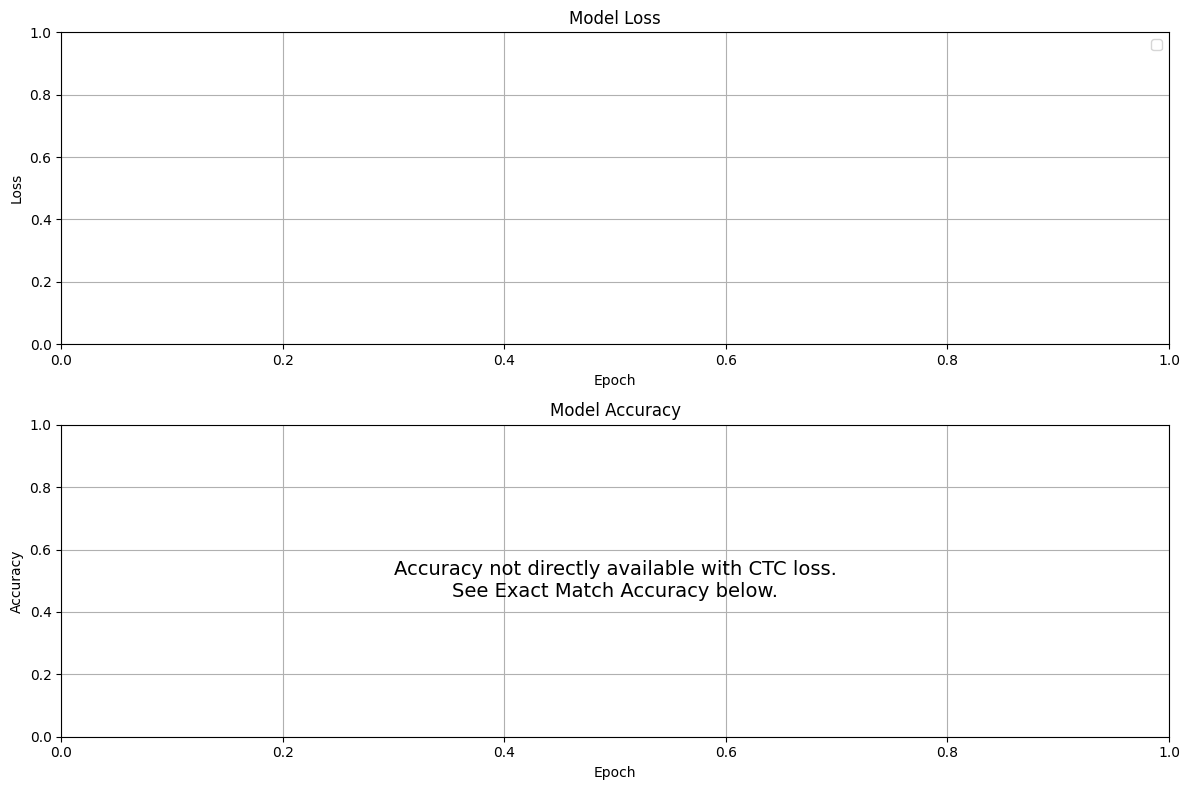


Evaluation Metrics:
Exact Match Accuracy: 0.6139
F1 Score (Character-Level): 0.7514
AUC Score (Character-Level): 0.8615


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import keras

# Ensure CTCLayer is defined
@keras.saving.register_keras_serializable()
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

    def get_config(self):
        config = super().get_config()
        return config

def decode_batch_predictions(pred, max_len, num_to_char):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_len]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

def calculate_metrics(prediction_model, test_set, max_len, num_to_char, char_to_num):
    all_true_chars = []
    all_pred_chars = []
    exact_matches = 0
    total_samples = 0
    true_labels = []
    pred_labels = []

    for batch in test_set:
        images = batch["image"]
        labels = batch["label"]
        preds = prediction_model.predict(images, verbose=0)
        pred_texts = decode_batch_predictions(preds, max_len, num_to_char)

        # Convert labels to text
        true_texts = []
        for label in labels:
            label = tf.gather(label, tf.where(tf.math.not_equal(label, PADDING_TOKEN)))
            text = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
            true_texts.append(text)

        # Exact Match Accuracy
        for true_text, pred_text in zip(true_texts, pred_texts):
            total_samples += 1
            if true_text == pred_text:
                exact_matches += 1

        # Character-level metrics for F1 and AUC
        for true_text, pred_text in zip(true_texts, pred_texts):
            true_chars = list(true_text)
            pred_chars = list(pred_text)[:len(true_chars)]  # Truncate or pad
            if len(pred_chars) < len(true_chars):
                pred_chars.extend([''] * (len(true_chars) - len(pred_chars)))
            all_true_chars.extend(true_chars)
            all_pred_chars.extend(pred_chars)
            true_labels.append(true_text)
            pred_labels.append(pred_text)

    # Exact Match Accuracy
    exact_match_accuracy = exact_matches / total_samples if total_samples > 0 else 0.0

    # F1 Score (character-level)
    vocab = char_to_num.get_vocabulary()
    lb = LabelBinarizer()
    lb.fit(vocab + [''])  # Include empty string for padding
    true_char_encoded = lb.transform(all_true_chars)
    pred_char_encoded = lb.transform(all_pred_chars)
    f1 = f1_score(true_char_encoded, pred_char_encoded, average='weighted', zero_division=0)

    # AUC Score (character-level)
    try:
        auc = roc_auc_score(true_char_encoded, pred_char_encoded, average='weighted', multi_class='ovo')
    except ValueError:
        auc = 0.0  # Handle cases where AUC is not computable

    return {
        'exact_match_accuracy': exact_match_accuracy,
        'f1_score': f1,
        'auc_score': auc
    }

def plot_training_metrics():
    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)
    checkpoint_dir = '/content/drive/MyDrive/model_checkpoints'
    history_path = os.path.join(checkpoint_dir, 'training_history.pkl')

    # Load training history
    if not os.path.exists(history_path):
        print(f"Training history file {history_path} not found.")
        return
    try:
        with open(history_path, 'rb') as f:
            history = pickle.load(f)  # Now loading history.history dict
        print(f"Loaded training history from {history_path}")
    except Exception as e:
        print(f"Error loading training history: {e}")
        return

    # Plotting
    plt.figure(figsize=(8, 4))  # Reduced width for a more compact plot

    # Plot Loss
    if 'loss' in history:
        plt.plot(history['loss'], label='Training Loss', color='blue', linewidth=1.5)
    else:
        print("Training loss not found in history.")
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='Validation Loss', color='orange', linewidth=1.5)
    else:
        print("Validation loss not found in history.")
    plt.title('Model Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.legend(fontsize=8)
    plt.grid(True)

    plt.tight_layout()

    # Save plot as high-quality PDF
    pdf_path = os.path.join(checkpoint_dir, 'training_loss_plot.pdf')
    plt.savefig(pdf_path, format='pdf', dpi=300, bbox_inches='tight')
    print(f"Plot saved as PDF at {pdf_path}")

    plt.show()

    # Calculate additional metrics
    try:
        metrics = calculate_metrics(prediction_model, test_set, max_len, num_to_char, char_to_num)
        print("\nEvaluation Metrics:")
        print(f"Exact Match Accuracy: {metrics['exact_match_accuracy']:.4f}")
        print(f"F1 Score (Character-Level): {metrics['f1_score']:.4f}")
        print(f"AUC Score (Character-Level): {metrics['auc_score']:.4f}")
    except NameError as e:
        print(f"Error: {e}. Ensure prediction_model, test_set, max_len, num_to_char, char_to_num, and PADDING_TOKEN are defined.")
    except Exception as e:
        print(f"Error calculating metrics: {e}")

# Run the visualization and metrics calculation
plot_training_metrics()

Using character 'e' as the positive class for ROC curve.


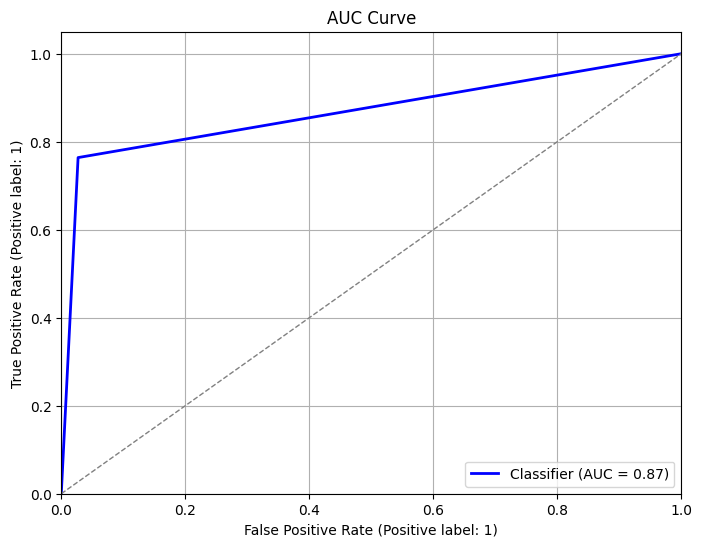

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def plot_roc_curve():
    # Collect true and predicted characters
    all_true_chars = []
    all_pred_chars = []

    try:
        for batch in test_set:
            images = batch["image"]
            labels = batch["label"]
            preds = prediction_model.predict(images, verbose=0)

            # Decode predictions
            input_len = np.ones(preds.shape[0]) * preds.shape[1]
            results = tf.keras.backend.ctc_decode(preds, input_length=input_len, greedy=True)[0][0][:, :max_len]
            pred_texts = []
            for res in results:
                res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
                res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
                pred_texts.append(res)

            # Convert labels to text
            true_texts = []
            for label in labels:
                label = tf.gather(label, tf.where(tf.math.not_equal(label, PADDING_TOKEN)))
                text = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                true_texts.append(text)

            # Character-level comparison
            for true_text, pred_text in zip(true_texts, pred_texts):
                true_chars = list(true_text)
                pred_chars = list(pred_text)[:len(true_chars)]
                if len(pred_chars) < len(true_chars):
                    pred_chars.extend([''] * (len(true_chars) - len(pred_chars)))
                all_true_chars.extend(true_chars)
                all_pred_chars.extend(pred_chars)

        # Select the most frequent character as the positive class
        vocab = char_to_num.get_vocabulary()
        char_counts = {}
        for char in all_true_chars:
            char_counts[char] = char_counts.get(char, 0) + 1
        positive_char = max(char_counts, key=char_counts.get)
        print(f"Using character '{positive_char}' as the positive class for ROC curve.")

        # Binarize: 1 if the character is the positive char, 0 otherwise
        y_true = [1 if char == positive_char else 0 for char in all_true_chars]
        y_pred = [1 if char == positive_char else 0 for char in all_pred_chars]

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)

        # Plotting
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'Classifier (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (Positive label: 1)')
        plt.ylabel('True Positive Rate (Positive label: 1)')
        plt.title('AUC Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    except NameError as e:
        print(f"Error: {e}. Ensure prediction_model, test_set, max_len, num_to_char, char_to_num, and PADDING_TOKEN are defined.")
    except Exception as e:
        print(f"Error plotting ROC curve: {e}")

# Run the ROC curve plot
plot_roc_curve()

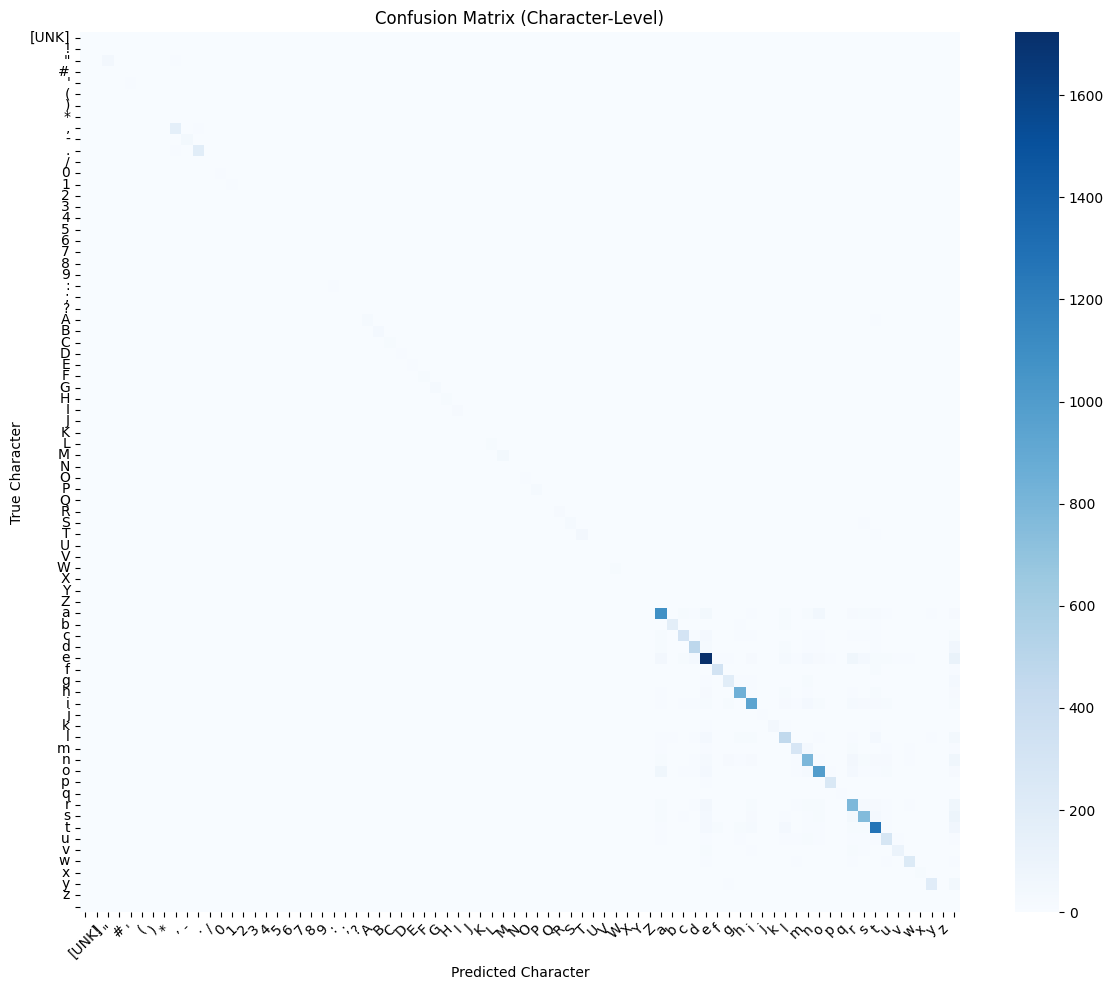

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix():
    # Collect true and predicted characters
    all_true_chars = []
    all_pred_chars = []

    try:
        for batch in test_set:
            images = batch["image"]
            labels = batch["label"]
            preds = prediction_model.predict(images, verbose=0)

            # Decode predictions
            input_len = np.ones(preds.shape[0]) * preds.shape[1]
            results = tf.keras.backend.ctc_decode(preds, input_length=input_len, greedy=True)[0][0][:, :max_len]
            pred_texts = []
            for res in results:
                res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
                res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
                pred_texts.append(res)

            # Convert labels to text
            true_texts = []
            for label in labels:
                label = tf.gather(label, tf.where(tf.math.not_equal(label, PADDING_TOKEN)))
                text = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                true_texts.append(text)

            # Character-level comparison
            for true_text, pred_text in zip(true_texts, pred_texts):
                true_chars = list(true_text)
                pred_chars = list(pred_text)[:len(true_chars)]
                if len(pred_chars) < len(true_chars):
                    pred_chars.extend([''] * (len(true_chars) - len(pred_chars)))
                all_true_chars.extend(true_chars)
                all_pred_chars.extend(pred_chars)

        # Get vocabulary
        vocab = char_to_num.get_vocabulary()
        labels = vocab + ['']  # Include empty string for padding/mismatches

        # Compute confusion matrix
        cm = confusion_matrix(all_true_chars, all_pred_chars, labels=labels)

        # Plotting
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix (Character-Level)')
        plt.xlabel('Predicted Character')
        plt.ylabel('True Character')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    except NameError as e:
        print(f"Error: {e}. Ensure prediction_model, test_set, max_len, num_to_char, char_to_num, and PADDING_TOKEN are defined.")
    except Exception as e:
        print(f"Error plotting confusion matrix: {e}")

# Run the confusion matrix plot
plot_confusion_matrix()

##Step 8: Inference
Here, we analyse samples of testing data to see if the model predicts properly.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


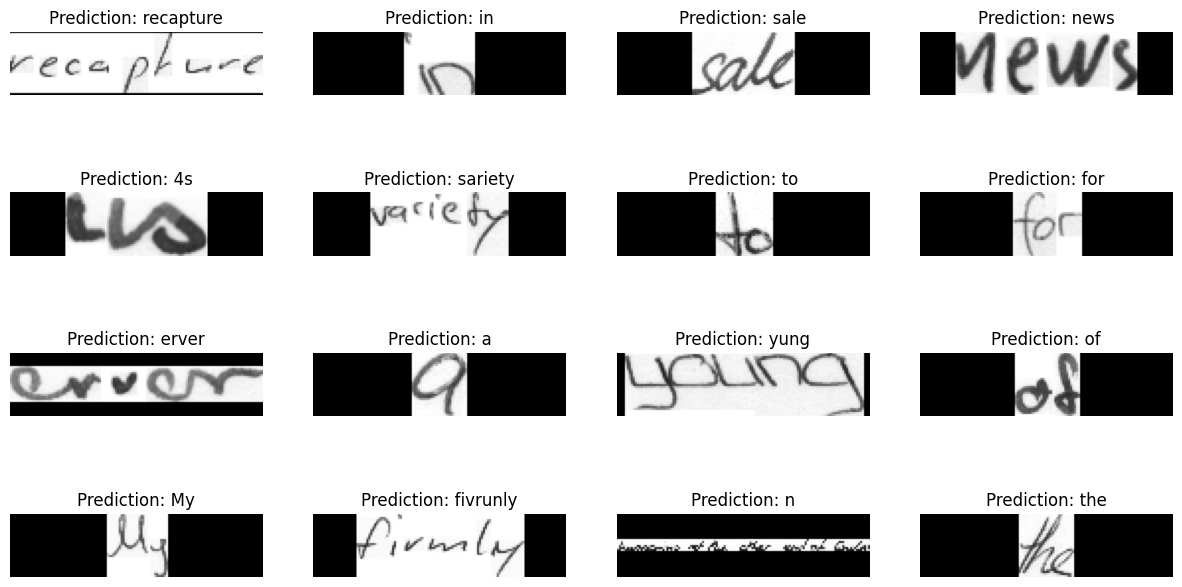

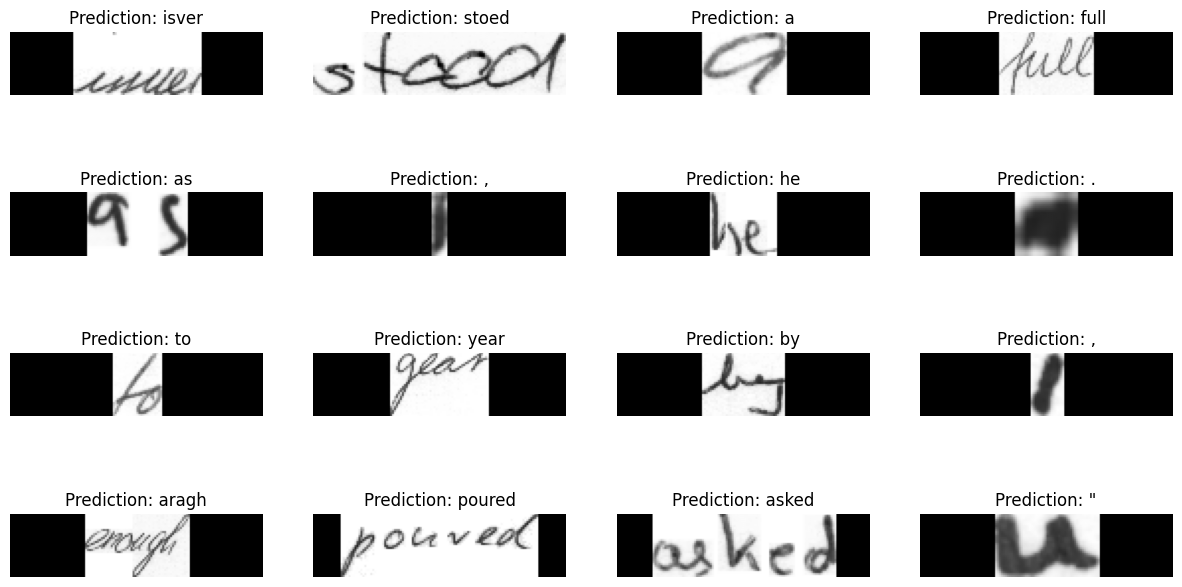

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]

    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_set.take(2):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

##Step 9: Prediction
For this, we've used unlabelled IAM dataset images for the prediction. We had only about 40,000 labelled images at our disposal, and we used the remaining unlabelled images for the same.

Please upload an image (PNG or JPEG) of a handwritten word.


Saving r06-137-10-00.png to r06-137-10-00.png


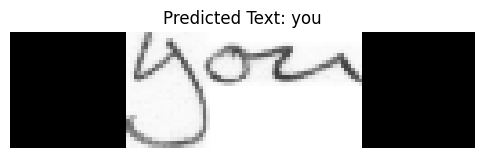

Predicted Text: you


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np

def predict_uploaded_image():
    # Upload image
    print("Please upload an image (PNG or JPEG) of a handwritten word.")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded.")
        return

    # Get the first uploaded file
    image_path = list(uploaded.keys())[0]

    # Preprocess the image
    image = preprocess_image(image_path, img_size=(128, 32))

    if image is None:
        print("Failed to preprocess image. Please upload a valid image.")
        return

    # Add batch dimension
    image = tf.expand_dims(image, axis=0)

    # Make prediction
    try:
        pred = prediction_model.predict(image, verbose=0)
        pred_text = decode_batch_predictions(pred)[0]
    except Exception as e:
        print(f"Error during prediction: {e}")
        return

    # Display image and prediction
    img = image[0]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    plt.figure(figsize=(6, 4))
    plt.imshow(img, cmap="gray")
    plt.title(f"Predicted Text: {pred_text}")
    plt.axis("off")
    plt.show()

    print(f"Predicted Text: {pred_text}")

# Run the prediction
predict_uploaded_image()